Importing packages

In [87]:
#Import packages
import importlib
import subprocess
import sys

def install_and_import(package, import_name=None):
    """
    Try to import a package. If it's not installed, install it via pip and import again.
    """
    if import_name is None:
        import_name = package

    try:
        return importlib.import_module(import_name)
    except ImportError:
        print(f"{import_name} not found, installing {package}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])
        return importlib.import_module(import_name)


# --- Install + import core packages ---
np = install_and_import("numpy")
pd = install_and_import("pandas")
plt = install_and_import("matplotlib", "matplotlib.pyplot")

# --- Install + import scikit-learn ---
sklearn = install_and_import("scikit-learn", "sklearn")

# Dataset & model selection
from sklearn.datasets import fetch_openml
from sklearn.model_selection import (
    train_test_split, KFold, GridSearchCV, cross_validate
)

# Preprocessing
from sklearn.compose import ColumnTransformer, make_column_selector as selector
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

# --- MODELS ---
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor

# --- METRICS
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.inspection import permutation_importance

print("All regression-related libraries imported successfully!")

All regression-related libraries imported successfully!


Loading the dataset

In [80]:
#Load the dataset
data = pd.read_csv("filtered_data_anal.csv")
print(data.head())

   site_id_(telephely)  class_size  teachers_number_site  math_score_8_std  \
0              2829211          18                 28.25         -1.675153   
1              3353709           9                 13.00          0.265037   
2              3359201          13                 13.00         -1.494051   
3              3511901          23                 37.00          0.166714   
4              3108801          27                 37.50          1.045846   

   total_students_site mother_education_level father_education_level  \
0                  266         primary_school         primary_school   
1                   82                college  apprenticeship_school   
2                  108         primary_school         primary_school   
3                  343                college  secondary_with_matura   
4                  393  secondary_with_matura  apprenticeship_school   

  books_at_home  family_background_index_std student_gender  \
0          0_50                    

Step 1: Train-test split

In [81]:
#Step 1: Naming the targetv variable and splitting the data
target_column = "math_score_8_std"

#Train-test split
from sklearn.model_selection import RepeatedKFold

# 20% hold out of the data for final evaluation
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=76678
)

print(f"Training samples: {X_train.shape[0]}, Test samples: {X_test.shape[0]}")


Training samples: 43789, Test samples: 10948


Step 2: Preprocessing for tree-based models

In [82]:
#Step 2: Identifying numeric and categorical features

numeric_features = selector(dtype_include=np.number)(X)
categorical_features = selector(dtype_include=object)(X)

# OneHotEncoder dense
ohe_dense = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

# Numeric pipeline: impute median
numeric_pipe_tree = Pipeline([
    ('impute', SimpleImputer(strategy='median'))
])

# Categorical pipeline: impute most frequent + one-hot encode
categorical_pipe_tree = Pipeline([
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('onehot', ohe_dense)
])

# Full preprocessor for tree models
preprocess_for_tree = ColumnTransformer([
    ('num', numeric_pipe_tree, numeric_features),
    ('cat', categorical_pipe_tree, categorical_features)
], remainder='drop', sparse_threshold=0.0)  # dense output


Step 3: Define repeated 5-fold cross-validation

In [83]:
#Step 3: Define repeated 5-fold cross-validation
from sklearn.model_selection import RepeatedKFold

# 5-fold CV repeated 5 times for stable estimates
cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=76678)


Step 4: Hyperparameter grids

In [84]:
#Step 4: Hyperparameter grids
#Decision tree
param_grid_tree = {
    'model__max_depth': [2, 5, 10, 20],
    'model__min_samples_leaf': [1, 5, 20]
}

#Random forest
param_grid_rf = {
    'model__n_estimators': [100, 300],
    'model__max_depth': [None, 10, 20],
    'model__min_samples_leaf': [1, 5],
    'model__max_features': ['sqrt', 'log2', 0.3]
}


Step 5: Build pipelines

In [85]:
#Step 5: Build pipelines
tree_pipe = Pipeline([
    ('preprocess', preprocess_for_tree),
    ('model', DecisionTreeRegressor(random_state=76678))
])
rf_pipe = Pipeline([
    ('preprocess', preprocess_for_tree),
    ('model', RandomForestRegressor(random_state=76678, n_jobs=-1))
])


Step 6: Grid search CV to find optimal hyperparameters

In [86]:
#Step 6: Grid search CV to find optimal hyperparameters
#TREE
tree_gs = GridSearchCV(
    tree_pipe,
    param_grid_tree,
    cv=cv,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)
tree_gs.fit(X_train, y_train)

print("Best Decision Tree params:", tree_gs.best_params_)
print("CV RMSE (mean of best):", -tree_gs.best_score_)

#RF
rf_gs = GridSearchCV(
    rf_pipe,
    param_grid_rf,
    cv=cv,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)
rf_gs.fit(X_train, y_train)

print("Best Random Forest params:", rf_gs.best_params_)
print("CV RMSE (mean of best):", -rf_gs.best_score_)


Best Decision Tree params: {'model__max_depth': 5, 'model__min_samples_leaf': 20}
CV RMSE (mean of best): 0.8378938906960272
Best Random Forest params: {'model__max_depth': 20, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 1, 'model__n_estimators': 300}
CV RMSE (mean of best): 0.8126601884599808


Step 7: Evaluate on held-out test set

In [88]:
#Step 7: Evaluate on held-out test set
# Decision Tree test evaluation
y_pred_tree = tree_gs.best_estimator_.predict(X_test)
print("\nDecision Tree Test Performance:")
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_tree)))
print("R²:", r2_score(y_test, y_pred_tree))
print("MAE:", mean_absolute_error(y_test, y_pred_tree))

# Random Forest test evaluation
y_pred_rf = rf_gs.best_estimator_.predict(X_test)
print("\nRandom Forest Test Performance:")
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_rf)))
print("R²:", r2_score(y_test, y_pred_rf))
print("MAE:", mean_absolute_error(y_test, y_pred_rf))



Decision Tree Test Performance:
RMSE: 0.8454470154452066
R²: 0.24569117727554968
MAE: 0.6739577978764844

Random Forest Test Performance:
RMSE: 0.8156670477471683
R²: 0.29789473169539815
MAE: 0.6478852253767095


Plotting the best decision tree

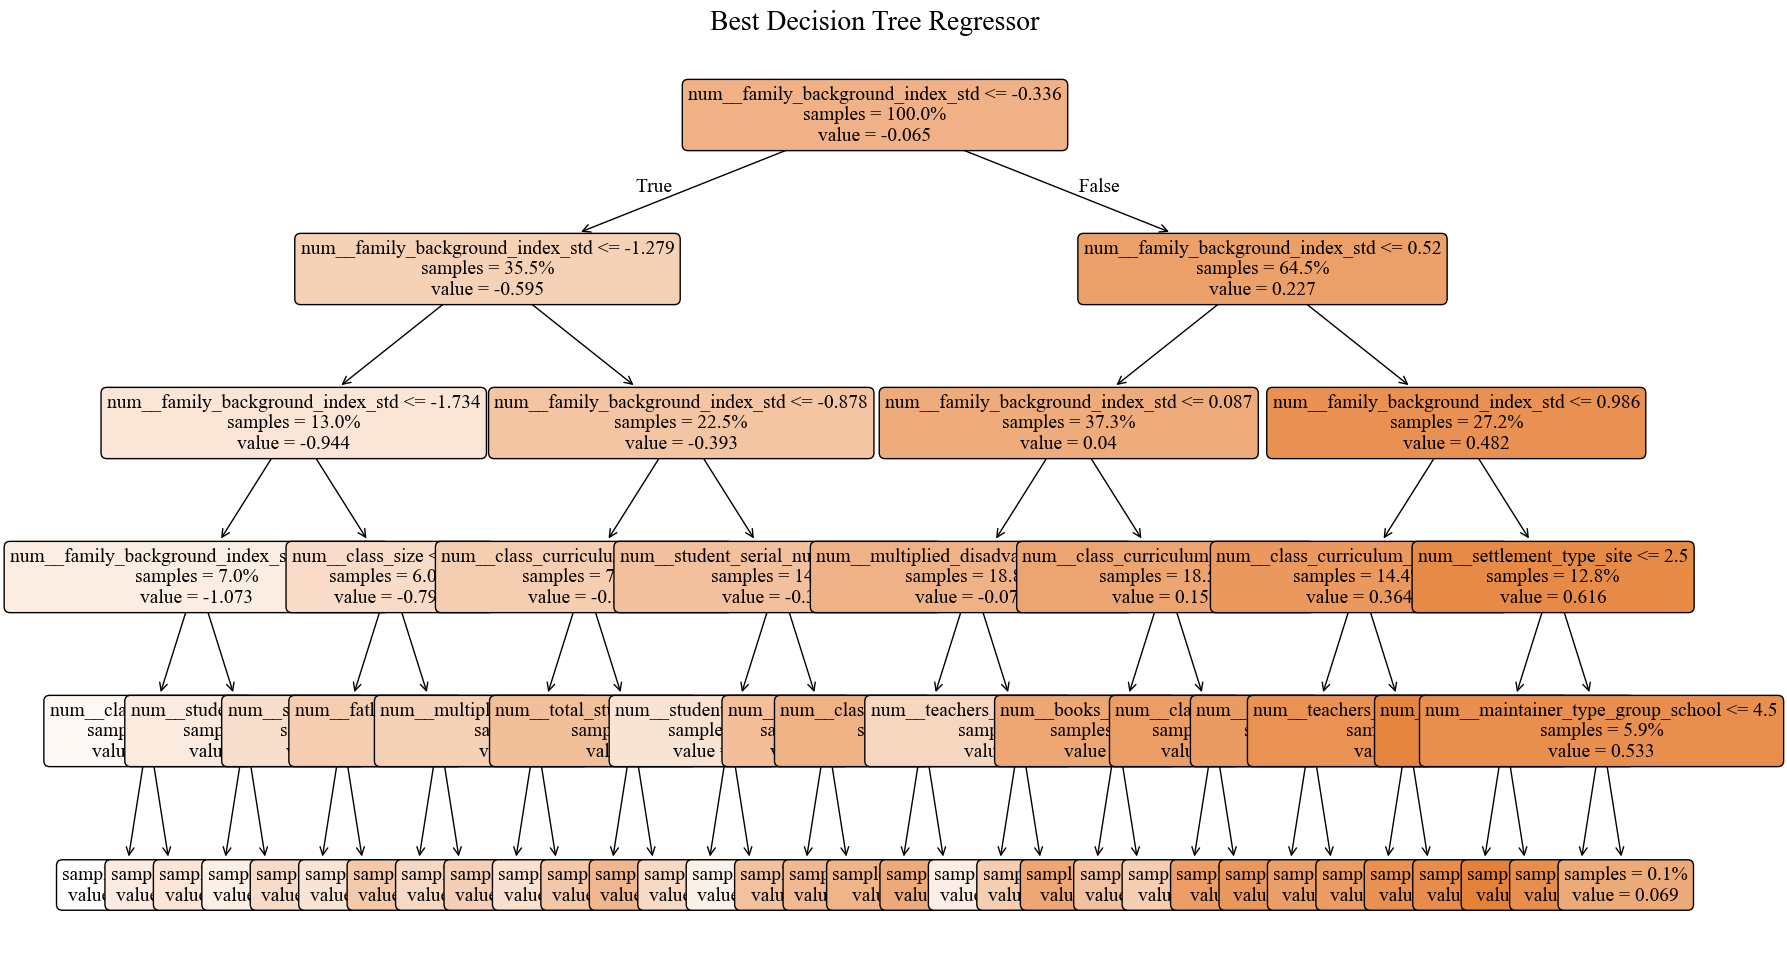

In [89]:
# Extract the best Decision Tree model from the GridSearchCV
best_tree_model = tree_gs.best_estimator_.named_steps['model']

plt.rcParams["font.family"] = "Times New Roman"

# Get feature names after preprocessing
feature_names = tree_gs.best_estimator_.named_steps['preprocess'].get_feature_names_out()

# Plot the tree
plt.figure(figsize=(20, 12))
plot_tree(
    best_tree_model,
    feature_names=feature_names,
    filled=True,
    rounded=True,
    fontsize=14,
    proportion=True,   # show proportion of samples
    impurity=False     # remove splitting criterion (e.g., MSE)
)
plt.title("Best Decision Tree Regressor", fontsize=20)
plt.show()


Calculating the importance of the variables in the best random forest

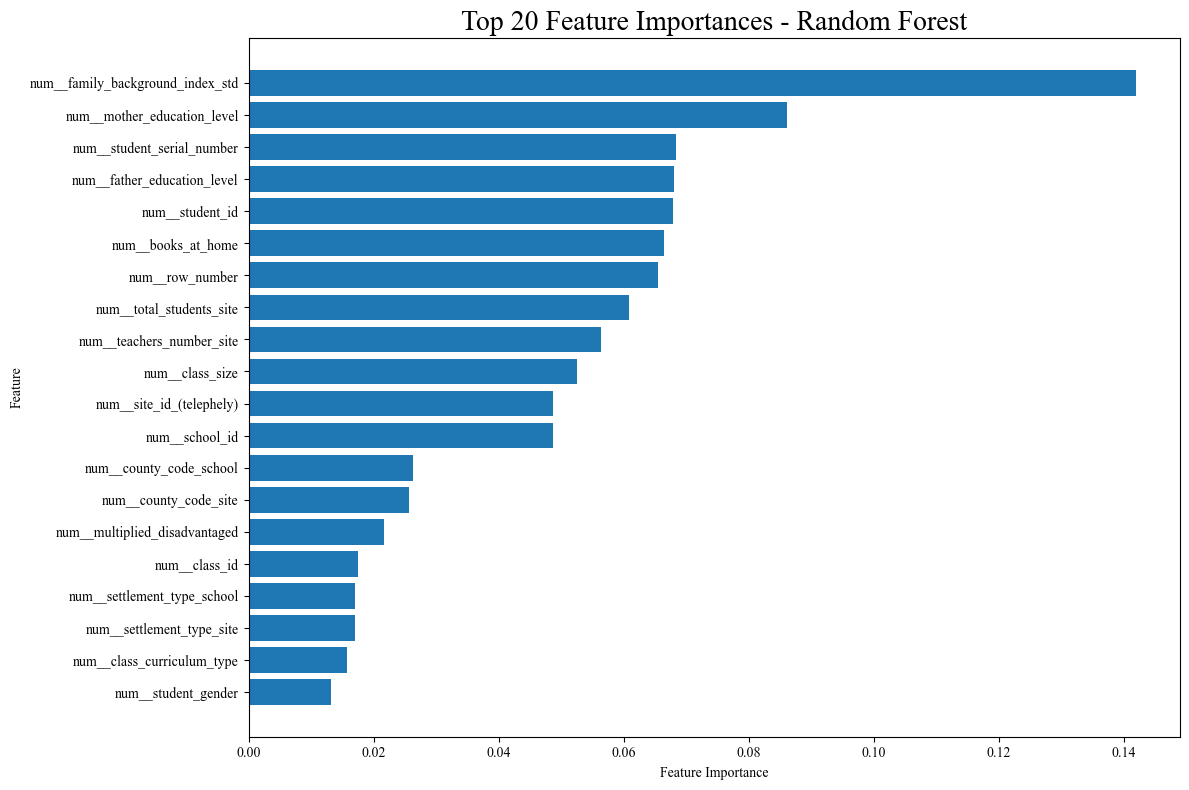

                              feature  importance
15   num__family_background_index_std    0.141888
12        num__mother_education_level    0.086173
3          num__student_serial_number    0.068323
13        num__father_education_level    0.068000
2                     num__student_id    0.067842
14                 num__books_at_home    0.066425
0                     num__row_number    0.065545
11           num__total_students_site    0.060844
5           num__teachers_number_site    0.056327
4                     num__class_size    0.052473
1            num__site_id_(telephely)    0.048654
19                     num__school_id    0.048633
20            num__county_code_school    0.026319
8               num__county_code_site    0.025711
18      num__multiplied_disadvantaged    0.021613
6                       num__class_id    0.017583
21        num__settlement_type_school    0.017079
9           num__settlement_type_site    0.017031
17         num__class_curriculum_type    0.015682


In [90]:
#9. Extract best Random Forest from GridSearchCV
best_rf_model = rf_gs.best_estimator_.named_steps['model']

# Get feature names after preprocessing
feature_names = rf_gs.best_estimator_.named_steps['preprocess'].get_feature_names_out()

# Get feature importances
importances = best_rf_model.feature_importances_

# Create a DataFrame for easier sorting and plotting
importances_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

# Plot top 20 features
plt.figure(figsize=(12, 8))
plt.barh(importances_df['feature'][:20][::-1], importances_df['importance'][:20][::-1])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Top 20 Feature Importances - Random Forest', fontsize=20)
plt.tight_layout()
plt.show()

print(importances_df)